In [2]:
import re
import os
import subprocess
import sys
from matplotlib import pyplot as plt
import pandas as pd


sys.path.append('../../')  # Add the path to the my_packages module
os.environ['EXPERIMENT_DB_NAME'] = "refinement_experiments"
from my_packages.analysis.error_analysis import categorize_semantic_errors, categorize_syntax_error, categorize_syntax_parsing_error, categorize_test_errors, extract_semantic_errors, extract_test_error, get_error_category_counts, make_categories_bar_chart, make_categories_pie_chart
from my_packages.db_service.error_service import delete_error_docs, errors_to_df, pretty_print_errors
from my_packages.evaluation.midio_compiler import compile_code, is_code_syntax_valid
from my_packages.db_service.experiment_service import experiment_exists, pretty_print_experiment_collections, run_experiment_quality_checks, setup_experiment_collection


experiment_names = [f"baseline_5_shot", f"RAG_5_shot"]
prompt_types = ["regular", "signature"]
models = ["phi4:14b-fp16", "llama3.2:3b-instruct-fp16", "llama3.3:70b-instruct-fp16"]


# Categorize and extract errors:
for experiment_name in experiment_names:
    print(f"\n\n Experiment: {experiment_name.capitalize()}")
    for prompt in prompt_types:
        print(f"    {prompt.upper()} prompts:")
        for model in models:
            print(f"\n      {model.upper()} model:\n")    
            filter = {
                "eval_method": "3_fold",
                "model_name": model,
                "phase": "testing", 
            }
            df = errors_to_df(f"{prompt}_{experiment_name}", filter=filter)
            # print(df.count())
            df["syntax_error"] = df["stderr"]
            df["syntax_parsing_error"] = df["stderr"].apply(categorize_syntax_parsing_error)
            df["syntax_category"] = df["stderr"].apply(categorize_syntax_error)

            df["semantic_error"] = df["error_msg"].apply(extract_semantic_errors)
            df["semantic_category"] = df["error_msg"].apply(categorize_semantic_errors)

            df["tests_category"] = df["test_result"].apply(categorize_test_errors)
            df["tests_error"] = df.apply(
                lambda row: extract_test_error(row["tests_category"], row["error_msg"], row["test_result"]),
                axis=1
            )
            error_type = ["syntax", "semantic"] if prompt == "regular" else ["syntax", "semantic", "tests"]

            for error_type in error_type:
                filtered_df = df[
                    (df["error_type"] == error_type) 
                    # & (df[f"{error_type}_category"] == {'Symbol Resolution Error'})
                    # & (df[f"syntax_parsing_error"] == '[Parsing failed]') 

                ]

                errors_count_df = get_error_category_counts(filtered_df, f"{error_type}_category")
                print(errors_count_df)

                # # Show all rows
                # pd.set_option('display.max_rows', None)     

                # # Show all columns
                # pd.set_option('display.max_columns', None)

                # # Show full content in each cell
                # pd.set_option('display.max_colwidth', None)

                # print(df["error_type"].unique())

    # make_categories_pie_chart(errors_count_df, title=f"{error_type.capitalize()} Error Categories")
    # make_categories_bar_chart(errors_count_df, title=f"{error_type.capitalize()} Error Categories")


    # filtered_df.head(50)





 Experiment: Baseline_5_shot
    REGULAR prompts:

      PHI4:14B-FP16 model:

         category  count  percentage
0  Parsing failed    804       100.0
                  category  count  percentage
0  Symbol Resolution Error   2281   47.789650
1    Type Resolution Error   1918   40.184370
2       Invalid connection    370    7.751938
3     Other Semantic Error    102    2.137021
4         Duplicate symbol     86    1.801802
5  Invalid function header     16    0.335219

      LLAMA3.2:3B-INSTRUCT-FP16 model:

              category  count  percentage
0       Parsing failed    954   98.452012
1  Tokenization failed     15    1.547988
                     category  count  percentage
0     Symbol Resolution Error    955   47.917712
1       Type Resolution Error    850   42.649272
2          Invalid connection     94    4.716508
3     Invalid function header     34    1.705971
4            Duplicate symbol     28    1.404917
5        Other Semantic Error     14    0.702459
6       Inval

# Syntax error comparrison

## Copy error collection to another db

In [ ]:
import os
import subprocess
import sys
sys.path.append('../../')  # Add the path to the my_packages module

from my_packages.db_service import get_db_connection



from_experiment = "context"
to_experiment = "refinement"
source_db = get_db_connection(f"{from_experiment}_experiments")
target_db = get_db_connection(f"{to_experiment}_experiments")

for prompt in ["regular", "signature"]:
    source_collection = source_db[f"{prompt}_RAG_5_shot_errors"]

    new_target_collection_name = f"{prompt}_baseline_5_shot_errors"
    if new_target_collection_name in target_db.list_collection_names():
        print(f"Collection {new_target_collection_name} already exists in {target_db.name} DB. Skipping.")
        continue
    target_collection = target_db[new_target_collection_name]

    docs = list(source_collection.find())  # Use list() to avoid cursor exhaustion
    if docs:
        target_collection.insert_many(docs)
        print(f"Copied {len(docs)} docs to  {new_target_collection_name} in {target_db.name} DB.")
    else:
        print(f"No documents found in {new_target_collection_name} in {target_db.name} DB.")


Collection regular_baseline_5_shot_errors already exists in refinement_experiments DB. Skipping.
Collection signature_baseline_5_shot_errors already exists in refinement_experiments DB. Skipping.


# Comparrison of experiemnts

                   model_name task_id  candidate_id  metric error_type  \
0  llama3.3:70b-instruct-fp16      41             2  syntax     syntax   
1  llama3.3:70b-instruct-fp16      41             7  syntax     syntax   
2  llama3.3:70b-instruct-fp16      23             7  syntax     syntax   
3  llama3.3:70b-instruct-fp16      23             4  syntax     syntax   

                                                                                                                                                                                                                                             error_msg  \
0  [ERROR compiler::frontend::parser: 1372: Error during parsing of file midio_example: CompilerError - Error: Expected token Identifier, but got Keyword(Trigger) at 1311, ERROR compiler::frontend::parser: 1373:     backtrace: disabled backtrace]   
1   [ERROR compiler::frontend::parser: 1372: Error during parsing of file midio_example: CompilerError - Error: Expected token Id

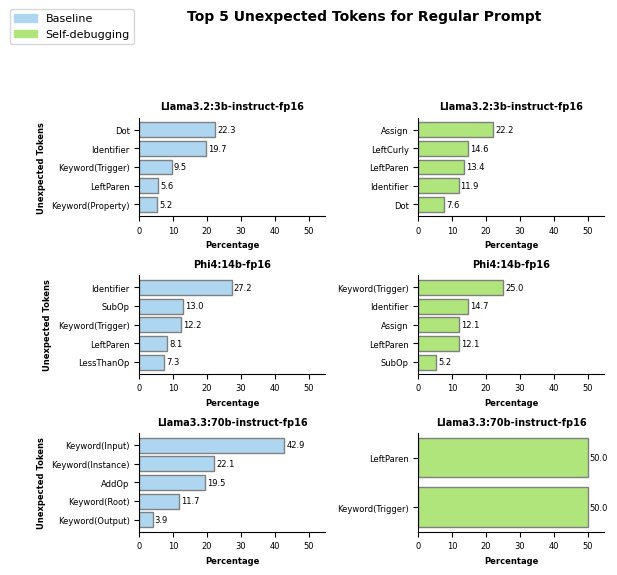

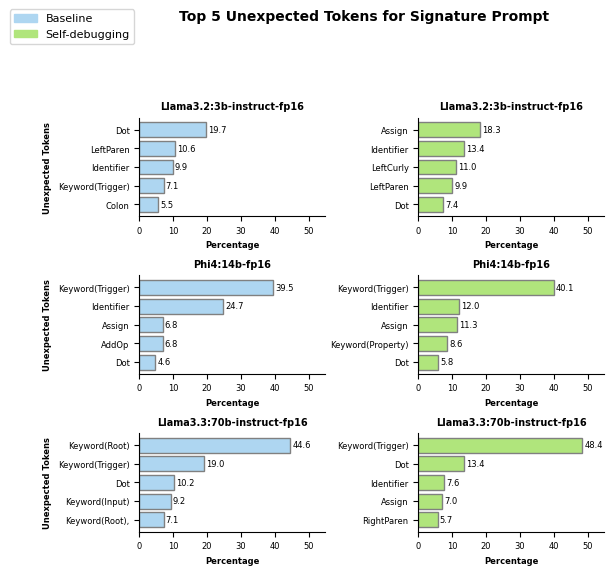

In [5]:
import re
import os
import subprocess
import sys
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# Show all rows
pd.set_option('display.max_rows', None)     

# Show all columns
pd.set_option('display.max_columns', None)

# Show full content in each cell
pd.set_option('display.max_colwidth', None)

experiment = "refinement_experiments"

experiment_types = ["baseline", "RAG"]
color_map = {
    "baseline": "#aed6f1",
    "RAG": "#b0e57c",
    # "full-context": "#b0e57c",
}
#aed6f1
models = ["llama3.2:3b-instruct-fp16", "phi4:14b-fp16", "llama3.3:70b-instruct-fp16"]
prompts = ["regular", "signature"]
shot = 5

os.environ['EXPERIMENT_DB_NAME'] = experiment

sys.path.append('../../')  # Add the path to the my_packages module
from my_packages.analysis.error_analysis import (
    categorize_semantic_errors, 
    categorize_syntax_error, 
    categorize_syntax_parsing_error,
    categorize_test_errors, 
    extract_semantic_errors, 
    extract_test_error, 
    get_error_category_counts, 
    make_categories_bar_chart, 
    make_categories_pie_chart
)
from my_packages.db_service.error_service import delete_error_docs, errors_to_df, pretty_print_errors
from my_packages.evaluation.midio_compiler import compile_code, is_code_syntax_valid
from my_packages.db_service.experiment_service import experiment_exists, pretty_print_experiment_collections, run_experiment_quality_checks, setup_experiment_collection

def categorize_erors(experiment_name: str,
                     metric: str,
                     filter: dict
                    ):
    # Categorize and extract errors
    df = errors_to_df(experiment_name, filter=filter)
    if metric == "syntax":
        df["syntax_error"] = df["stderr"]
        df["syntax_parsing_error"] = df["stderr"].apply(categorize_syntax_parsing_error)
        df["syntax_category"] = df["stderr"].apply(categorize_syntax_error)
    elif metric == "semantic":
        df["semantic_error"] = df["error_msg"].apply(extract_semantic_errors)
        df["semantic_category"] = df["error_msg"].apply(categorize_semantic_errors)
    elif metric == "tests":
        df["tests_category"] = df["test_result"].apply(categorize_test_errors)
        df["tests_error"] = df.apply(
            lambda row: extract_test_error(row["tests_category"], row["error_msg"], row["test_result"]),
            axis=1
        )
    return df

def get_all_errors_comparison(metric, models, experiment_types, prompt, shot, parsing_errors = True):
    rows = []
    for model in models:
        for experiment_type in experiment_types:
            df = categorize_erors(
                experiment_name=f"{prompt}_{experiment_type}_{shot}_shot",
                metric=metric,
                filter={"eval_method": "3_fold", "model_name": model, "phase": "testing", "metric": metric},
            )
            if model == "llama3.3:70b-instruct-fp16" and experiment_type == "RAG" and prompt == "regular":
                print(df)
            filtered_df = df[df["error_type"] == metric]
            if parsing_errors:
                filtered_df = filtered_df[filtered_df["syntax_category"] == "Parsing failed"]
                errors_count_df = get_error_category_counts(filtered_df, f"{metric}_parsing_error")
            else:
                errors_count_df = get_error_category_counts(filtered_df, f"{metric}_category")
        
            # Loop over each error category row and append as individual rows
            # make_categories_pie_chart(errors_count_df, title=f"{error_type.capitalize()} Error Categories")
            # make_categories_bar_chart(errors_count_df, title=f"{error_type.capitalize()} Error Categories")
            for _, row in errors_count_df.iterrows():
                rows.append({
                    "model": model,
                    "prompt": prompt,
                    "experiment_type": experiment_type,
                    "shots": shot,
                    "category": row["category"],
                    "count": row["count"],
                    "percentage": row["percentage"],
                })
    return pd.DataFrame(rows)

if  "full-context" in experiment_types and "phi4:14b-fp16" in models:
    models.remove("phi4:14b-fp16")

# plt.rcParams.update({
#     "font.size": 10,              # Base font size
#     "axes.titlesize": 10,        # subplot titles (if any)
#     "axes.labelsize": 8,         # x/y labels
#     "xtick.labelsize": 10,        # tick labels
#     "ytick.labelsize": 10,
#     "legend.fontsize": 10,       # legend text
#     "figure.titlesize": 12       # suptitle
# })
for prompt in prompts:
     comparison_df = get_all_errors_comparison("syntax", models, experiment_types, prompt, shot, parsing_errors=True)

     rows = len(models)
     cols = len(experiment_types)
     fig, axs = plt.subplots(rows, cols, figsize=(cols*3, rows*2))  # Slightly shorter height

     for row_idx, model in enumerate(models):
         for col_idx, experiment_type in enumerate(experiment_types):
            ax = axs[row_idx, col_idx]
            df = comparison_df[
                 (comparison_df["experiment_type"] == experiment_type) & (comparison_df["model"] == model)
             ]

            df = df.sort_values(by="percentage", ascending=False).head(5)
            df = df.sort_values(by="percentage", ascending=True)

            bars = ax.barh(
                 df["category"],
                 df["percentage"],
                 color=color_map[experiment_type],
                 edgecolor="gray"
             )

            for bar in bars:
                 width = bar.get_width()
                 ax.text(
                     width + 0.6,
                     bar.get_y() + bar.get_height()/2,
                     f"{width:.1f}",
                     va="center",
                     fontsize=6,
                 )
             # Enhance title
            model_label = model.capitalize().removesuffix("-FP16")
            ax.set_title(model_label, fontsize=7, fontweight='bold')
            ax.set_xlim(0, 55)
            ax.set_xlabel("Percentage", fontsize=6, fontweight='bold')
            ax.set_ylabel(f"Unexpected Tokens", fontsize=6, fontweight='bold') if col_idx == 0 else ax.set_ylabel("")

            ax.tick_params(axis='both', labelsize=6)
            ax.spines[['top', 'right']].set_visible(False)

     # Adjust spacing between subplots
     fig.suptitle(f"Top 5 Unexpected Tokens for {prompt.capitalize()} Prompt\n", fontsize=10, fontweight='bold')
     legend_handles = [
         mpatches.Patch(color=color, label=("Self-debugging" if label == "RAG" else "Baseline"))
         for label, color in color_map.items()
     ]

     fig.legend(
        handles=legend_handles,
        title="",
        loc='upper left',
        bbox_to_anchor=(-0.10, 0.99),  # shift further left (was 0.01)
        fontsize=8,
        title_fontsize=8,
    )


     plt.subplots_adjust(wspace=0.50, hspace=0.6, top=0.80)

     # plt.tight_layout(pad=0.1)

     plt.savefig(
         f"{prompt}_top5_unexpected_tokens_all_models_compact.png", 
         dpi=400,
         bbox_inches="tight",    # ← expand the saved region to include all artists
         pad_inches=0.1          # ← a little padding around the edges
)
     plt.show()


# Comparrison of prompt types

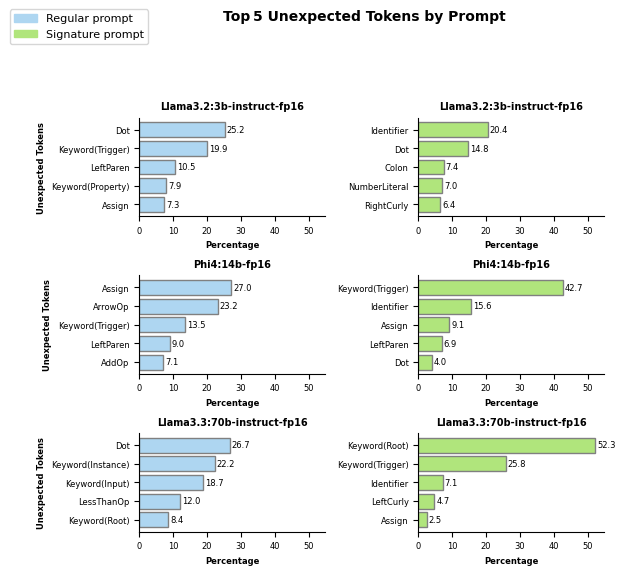

Saved figure to prompt_comparison_top5_unexpected_tokens.png


In [ ]:
import os, sys, pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
sys.path.append('../../')  # Add the path to the my_packages module
experiment = "few_shot_experiments"
os.environ["EXPERIMENT_DB_NAME"] = experiment

from my_packages.analysis.error_analysis import (
    categorize_semantic_errors, categorize_syntax_error,
    categorize_syntax_parsing_error, categorize_test_errors,
    extract_semantic_errors, extract_test_error,
    get_error_category_counts
)
from my_packages.db_service.error_service import errors_to_df

# ---------------------------------------------------------------------------
# CONFIG
# ---------------------------------------------------------------------------

models   = ["llama3.2:3b-instruct-fp16", "phi4:14b-fp16", "llama3.3:70b-instruct-fp16"]
prompts  = ["regular", "signature"]          # <- we now compare prompts
shot     = 5
experiment_types = ["similarity"]              # <- keep one (or set to the type you want)

color_map = {                                # colour keyed by prompt
    "regular":   "#aed6f1",
    "signature": "#b0e57c",
}

# ---------------------------------------------------------------------------
# HELPER
# ---------------------------------------------------------------------------
def categorize_errors(experiment_name: str, metric: str, _filter: dict):
    df = errors_to_df(experiment_name, filter=_filter)
    if metric == "syntax":
        df["syntax_error"]        = df["stderr"]
        df["syntax_parsing_error"]= df["stderr"].apply(categorize_syntax_parsing_error)
        df["syntax_category"]     = df["stderr"].apply(categorize_syntax_error)
    elif metric == "semantic":
        df["semantic_error"]      = df["error_msg"].apply(extract_semantic_errors)
        df["semantic_category"]   = df["error_msg"].apply(categorize_semantic_errors)
    elif metric == "tests":
        df["tests_category"]      = df["test_result"].apply(categorize_test_errors)
        df["tests_error"]         = df.apply(
             lambda r: extract_test_error(r["tests_category"], r["error_msg"], r["test_result"]),
             axis=1
        )
    return df

def get_all_errors_comparison(metric, models, prompt, experiment_type, shot, parsing_errors=True):
    rows = []
    for model in models:
        df = categorize_errors(
            experiment_name=f"{prompt}_{experiment_type}_{shot}_shot",
            metric=metric,
            _filter={"eval_method": "3_fold", "model_name": model, "phase": "testing"},
        )
        filtered_df = df[df["error_type"] == metric]
        if parsing_errors and metric == "syntax":
            filtered_df = filtered_df[filtered_df["syntax_category"] == "Parsing failed"]
            counts_df   = get_error_category_counts(filtered_df, f"{metric}_parsing_error")
        else:
            counts_df   = get_error_category_counts(filtered_df, f"{metric}_category")

        for _, row in counts_df.iterrows():
            rows.append({
                "model":      model,
                "prompt":     prompt,
                "category":   row["category"],
                "count":      row["count"],
                "percentage": row["percentage"],
            })
    return pd.DataFrame(rows)

# ---------------------------------------------------------------------------
# BUILD DATAFRAME (one call per prompt) & CONCAT
# ---------------------------------------------------------------------------
dfs = [
    get_all_errors_comparison("syntax", models, prompt, experiment_types[0], shot, parsing_errors=True)
    for prompt in prompts
]
comparison_df = pd.concat(dfs, ignore_index=True)

# ---------------------------------------------------------------------------
# PLOT
# ---------------------------------------------------------------------------
rows, cols = len(models), len(prompts)
fig, axs   = plt.subplots(rows, cols, figsize=(cols*3, rows*2))

for r_idx, model in enumerate(models):
    for c_idx, prompt in enumerate(prompts):
        ax = axs[r_idx, c_idx]
        df = comparison_df[(comparison_df["prompt"] == prompt) & (comparison_df["model"] == model)]
        df = df.sort_values("percentage", ascending=False).head(5).sort_values("percentage")

        bars = ax.barh(
            df["category"],
            df["percentage"],
            color=color_map[prompt],
            edgecolor="gray"
        )
        for bar in bars:
            w = bar.get_width()
            ax.text(w + 0.6, bar.get_y() + bar.get_height()/2, f"{w:.1f}", va="center", fontsize=6)

        ax.set_title(model.capitalize().removesuffix("-Fp16"), fontsize=7, fontweight="bold")
        ax.set_xlim(0, 55)
        ax.set_xlabel("Percentage", fontsize=6, fontweight="bold")
        ax.set_ylabel("Unexpected Tokens" if c_idx == 0 else "", fontsize=6, fontweight="bold")
        ax.tick_params(axis="both", labelsize=6)
        ax.spines[["top", "right"]].set_visible(False)

fig.suptitle("Top 5 Unexpected Tokens by Prompt\n", fontsize=10, fontweight="bold")
legend_handles = [mpatches.Patch(color=color_map[p], label=p.capitalize() + " prompt") for p in prompts]
fig.legend(handles=legend_handles, loc="upper left", bbox_to_anchor=(-0.10, 0.99), fontsize=8)

plt.subplots_adjust(wspace=0.50, hspace=0.6, top=0.80)
out_path = "prompt_comparison_top5_unexpected_tokens.png"
plt.savefig(out_path, dpi=400, bbox_inches="tight", pad_inches=0.1)
plt.show()
print(f"Saved figure to {out_path}")
